# **PROYECTO TFM**
 ## Segmentación e Identificación de Edificios en Imágenes Satelitales

## Objetivo
El objetivo de este trabajo es desarrollar un modelo de segmentación semántica capaz de identificar edificios en imágenes satelitales de alta resolución, utilizando datasets públicos (SpaceNet, Mapping Challenge, Inria y Massachusetts) y redes neuronales convolucionales.

Importacion de librerias

In [14]:
# Importacion de liberias necesarias para el programa
#import imageio
import cv2
from skimage import measure, morphology
from scipy import ndimage
# ============================================
# 📦 Librerías básicas y utilidades
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.measure import label
from skimage.morphology import local_maxima
#from PIL import Image
# ============================================
# 🧠 TensorFlow / Keras
# ============================================
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.data import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import *
from keras_unet_collection import transformer_layers
from keras_unet_collection import models
# Primero se comprueba si tenemos la GPU instalada
print("TensorFlow:", tf.__version__)
print("GPU detectada:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.10.0
GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Preparación del entorno de trabajo y procesamiento (pre y pos) de imágenes (incluyendo data augmentation)

In [15]:
# ============================================
# Direccion de los datasets
# ============================================
dataset_final = "../DATASETS/DATASET_FINAL/splits_300"
train_dir = f"{dataset_final}/train"
val_dir = f"{dataset_final}/val"
test_dir = f"{dataset_final}/test"


# ============================================
# Configuracion del dataset (tamaño, tipo...)
# ============================================
# Cantidad de datos (se reduce por disminuir tiempo de entrenamiento)
cantida_imagenes_entrenamiento = 46667
cantida_imagenes_validacion   = 14582
cantida_imagenes_test  = 14581

# Configuraciones para cargar las imagenes
ancho_imagen, alto_imagen = 128, 128  # Tamaños de la imagen
batch_size = 8 # Tamaño de batch para el entrenamiento
seed = 42 # Para evitar aleatoridad a la hora de entrenar el modelo
AUTOTUNE = tf.data.AUTOTUNE # Para acelerar el pipeline de datos

In [16]:
#############################################
#--------------------------------------------
# Disminuir tamaño dataset
#--------------------------------------------
#############################################

# Disminuimos el tamaño del dataset para disminuir el tiempo del entrenamiento
def coger_dataset_pequenio(image_dir, mask_dir, n):
    # Listado de archivos
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")]) # Listamos las imagenes en un orden
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")]) # Listamos las mascaras en un orden (asi se "junta" con la imagen)

    # Mezclar y tomar n archivos
    combined = list(zip(image_files, mask_files))
    #random.seed(42) # Garantiza la reproducibiliadad
    #random.shuffle(combined)
    subset = combined[:n]

    subset_images = [os.path.join(image_dir, x[0]) for x in subset]
    subset_masks  = [os.path.join(mask_dir, x[1]) for x in subset]

    # Crear tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((subset_images, subset_masks))
    ds = ds.shuffle(buffer_size=len(subset), seed=42, reshuffle_each_iteration=True)
    return ds

# Cogemos los 3 dataset con la funcion para dismiuir el tamaño y tiempo den entrenamiento

# Imagenes para train
train_ds_small = coger_dataset_pequenio(os.path.join(train_dir,"images"),
                                        os.path.join(train_dir,"masks"),
                             cantida_imagenes_entrenamiento)

# Imagenes para val
val_ds_small = coger_dataset_pequenio(os.path.join(val_dir,"images"),
                                      os.path.join(val_dir,"masks"),
                           cantida_imagenes_validacion)

# Imagenes para test
test_ds_small = coger_dataset_pequenio(os.path.join(test_dir,"images"),
                                       os.path.join(test_dir,"masks"),
                            cantida_imagenes_test)

Tras reducir el tamanio y descubri que tf.data.Dataset.from_tensor_slices une las máscaras y las imagenes más facilmente se opto por eliminar tf.keras.utils.image_dataset_from_directory

In [17]:
def cargar_imagenes_mascaras(image_dir, mask_dir, aplicar_data_augmentation):
    # Leemos la imagen
    image = tf.io.read_file(image_dir) # Lectura de imagen
    image = tf.image.decode_png(image, channels=3) # Decoder los canales (RGB)
    image = tf.image.resize(image, [ancho_imagen, alto_imagen]) # Ajustamos el ancho y el alto a la configuracion anterior
    image = tf.cast(image, tf.float32)/255.0 # Normalizamos la imagen

    # Leemos la máscara (igual que en imagen pero en un solo canal en este caso)
    mask = tf.io.read_file(mask_dir)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [ancho_imagen, alto_imagen])
    mask = tf.cast(mask > 0, tf.float32)

    # Aplicamos data augmentation (opcional pero recomendable)
    if aplicar_data_augmentation:
        # Flip horizontal si es mayor de 0.5
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask  = tf.image.flip_left_right(mask)
        # Flip vertical si es mayor de 0.5
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask  = tf.image.flip_up_down(mask)
        # Rotación 90° aleatoria
        k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask  = tf.image.rot90(mask, k)
        # Cambios de brillo/contraste solo en la imagen
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

        # Recorte aleatorio (simula zoom)
        combined = tf.concat([image, mask], axis=-1)  # unir para que ambos se recorten igual
        combined = tf.image.random_crop(combined, size=[alto_imagen, ancho_imagen, 4])
        image = combined[..., :3]
        mask  = combined[..., 3:]
    # Después de todas las augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    mask = tf.clip_by_value(mask, 0.0, 1.0)
    # Asegurar la forma correcta
    image = tf.reshape(image, [alto_imagen, ancho_imagen, 3])
    mask  = tf.reshape(mask, [alto_imagen, ancho_imagen, 1])
    return image, mask

In [18]:
train_ds_unet = (
    train_ds_small
        .map(lambda x, y: cargar_imagenes_mascaras(x, y, aplicar_data_augmentation=True),
             num_parallel_calls=AUTOTUNE)
        .shuffle(1000)       # barajar solo entrenamiento
        .batch(batch_size)   # agrupar en batches
        .prefetch(AUTOTUNE)  # cargar el siguiente batch mientras la GPU entrena
)

val_ds_unet = (
    val_ds_small
        .map(lambda x, y: cargar_imagenes_mascaras(x, y, aplicar_data_augmentation=False),
             num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
)

test_ds_unet = (
    test_ds_small
        .map(lambda x, y: cargar_imagenes_mascaras(x, y, aplicar_data_augmentation=False),
             num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
)

In [7]:
for imgs, masks in train_ds_unet.take(1):
    print(imgs.shape, masks.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


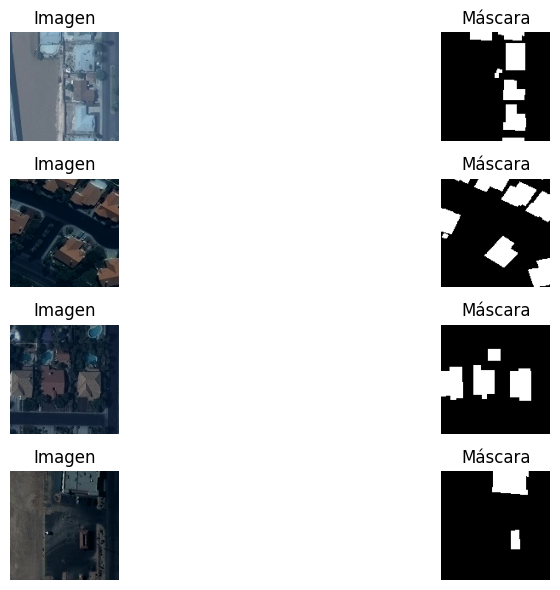

In [8]:
# Ahora visualizamos 4 imagenes con sus máscaras para ver como va
num_examples = 4  # cuántas imágenes del batch quieres mostrar
plt.figure(figsize=(12, 6))
# Tomamos solo un batch
for images, masks in train_ds_unet.take(1):
    break  # images: (batch_size, alto, ancho, 3), masks: (batch_size, alto, ancho, 1)
for i in range(num_examples):
    # Imagen
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())  # clip para evitar warnings
    plt.title("Imagen")
    plt.axis("off")

    # Máscara
    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(tf.clip_by_value(masks[i], 0.0, 1.0).numpy().squeeze(), cmap='gray')
    plt.title("Máscara")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [1]:
# Forma correcta para tu U-Net clásico
img_size = (alto_imagen, ancho_imagen)  # solo alto y ancho
num_classes = 1
model = models.swin_unet_2d(
    (128,128, 3),
    filter_num_begin=32,
    n_labels=num_classes,
    depth=4,
    stack_num_down=2,
    stack_num_up=2,
    patch_size=(4, 4),
    num_heads=[4, 8, 8, 8],
    window_size=[4, 2, 2, 2],
    num_mlp=156,
    output_activation='Sigmoid',
    shift_window=True,
    name='swin_unet'
)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
model.summary()

NameError: name 'alto_imagen' is not defined

In [19]:
# Creamos funciones de todas las metricas

# Funcion con la métrica de dice_coeficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calcula Dice Coefficient por imagen y luego promedio sobre batch.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Aplanamos por imagen: shape (batch, H*W*C)
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    denominator = tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1)

    dice = (2. * intersection + smooth) / (denominator + smooth)
    return tf.reduce_mean(dice)

# ==========================
# IoU (Jaccard Index, batch-wise)
# ==========================
def iou(y_true, y_pred, smooth=1e-6, threshold=0.5):
    """
    Calcula Intersection over Union por imagen y luego promedio sobre batch.
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred_bin, [tf.shape(y_pred_bin)[0], -1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=1) - intersection

    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score)


In [20]:
# Ahora creamos una función para las callbacks y asi "mejorar" el entrenamiento

# Funcion de pérdida para IoU y mejorar el entrenamiento
def iou_loss(y_true, y_pred, smooth=1e-6):
    """
    IoU Loss para segmentación binaria.
    Se minimiza 1 - IoU.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Aplanamos
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    # Intersección y unión
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=1) - intersection

    iou_score = (intersection + smooth) / (union + smooth)

    # Loss = 1 - IoU
    return 1 - tf.reduce_mean(iou_score)


# Ahora creamos los callbacks para mejorar el entrenamiento

# ModelCheckpoint para guardar el mejor modelo
checkpoint_cb = ModelCheckpoint(
    "best_model_swim_unet.h5",
    monitor="val_dice_coefficient",  # o "val_iou"
    save_best_only=True,
    mode="max",
    verbose=1
)

# Earlystopping: para que deje de entrenar el modelo si no mejora
earlystop_cb = EarlyStopping(
    monitor="val_dice_coefficient",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

# reduce_lr_cb: reduce el ratio de aprendizaje si el modelo no mejora
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_dice_coefficient",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode="max",
    verbose=1
)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    iou_l = iou_loss(y_true, y_pred)
    return bce + iou_l

# Tensorboard: para visualizar pérdidas y métricas en tiempo real
tensorboard_cb = TensorBoard(
    log_dir="logs_unet_normal/",
    histogram_freq=1,
    write_graph=True,
    write_images=True
)
callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb, tensorboard_cb]

In [14]:
# Crear el optimizador
optimizador = Adam(learning_rate=1e-4)

model.compile(
    optimizer = optimizador,
    loss = combined_loss,
    metrics = [dice_coefficient, iou],
)

In [15]:
history = model.fit(
    train_ds_unet,
    validation_data = val_ds_unet,
    epochs = 30,
    callbacks = callbacks,
)

Epoch 1/30
5834/5834 [==============================] - ETA: 0s - loss: 1.0194 - dice_coefficient: 0.4965 - iou: 0.4226
Epoch 1: val_dice_coefficient improved from -inf to 0.58965, saving model to best_model_swim_unet.h5
5834/5834 [==============================] - 610s 102ms/step - loss: 1.0194 - dice_coefficient: 0.4965 - iou: 0.4226 - val_loss: 0.8658 - val_dice_coefficient: 0.5896 - val_iou: 0.5161 - lr: 1.0000e-04
Epoch 2/30
5834/5834 [==============================] - ETA: 0s - loss: 0.8799 - dice_coefficient: 0.5730 - iou: 0.4996
Epoch 2: val_dice_coefficient improved from 0.58965 to 0.62749, saving model to best_model_swim_unet.h5
5834/5834 [==============================] - 525s 90ms/step - loss: 0.8799 - dice_coefficient: 0.5730 - iou: 0.4996 - val_loss: 0.8165 - val_dice_coefficient: 0.6275 - val_iou: 0.5474 - lr: 1.0000e-04
Epoch 3/30
5833/5834 [============================>.] - ETA: 0s - loss: 0.8248 - dice_coefficient: 0.6024 - iou: 0.5306
Epoch 3: val_dice_coefficient im

In [21]:
# Ahora evaluamos el modelo
# Cogemos el modelo que guardamos durante el entrenamiento
modelo_guardado = load_model("best_model_swim_unet.h5",
                   custom_objects = {
                       "dice_coefficient": dice_coefficient,
                       "iou": iou,
                       "combined_loss": combined_loss,
                       # capas personalizadas de Swin-UNet
                       "patch_extract": transformer_layers.patch_extract,
                       "patch_embedding": transformer_layers.patch_embedding,
                       "patch_merging": transformer_layers.patch_merging,
                       "patch_expanding": transformer_layers.patch_expanding,
                       "SwinTransformerBlock": transformer_layers.SwinTransformerBlock
                   })

In [22]:
# Evaluar en validación
results = modelo_guardado.evaluate(val_ds_unet)

1823/1823 [==============================] - 65s 34ms/step - loss: 0.5501 - dice_coefficient: 0.7627 - iou: 0.6874


In [11]:
# Ahora imprimimos la evaluación
print(f"Perdida (combinacion de IoU y binary_crossentropy): {results[0]:.3f}")
print(f"Metrica Dice Coefficient: {results[1]:.3f}")
print(f"Metrica IoU: {results[2]:.3f}")

Perdida (combinacion de IoU y binary_crossentropy): 0.550
Metrica Dice Coefficient: 0.763
Metrica IoU: 0.687


1/1 [==============================] - 2s 2s/step


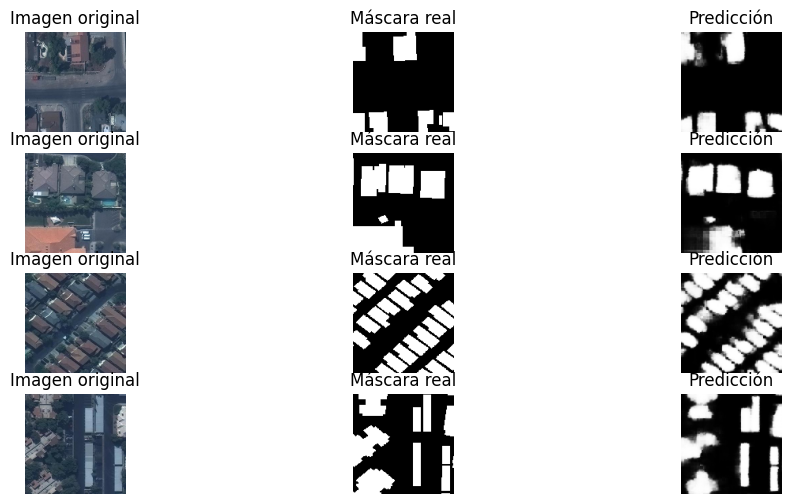

In [23]:
# Ahora visualizamos resultamos y vemos que tal
for batch in val_ds_unet.take(1):
    imagenes, mascaras = batch
    preds = modelo_guardado.predict(imagenes)

    # Visualizamos algunas imágenes
    num_ejemplos = 4
    plt.figure(figsize=(12, 6))
    for i in range(num_ejemplos):
        plt.subplot(num_ejemplos, 3, 3*i + 1)
        plt.imshow(imagenes[i].numpy())
        plt.title("Imagen original")
        plt.axis("off")

        plt.subplot(num_ejemplos, 3, 3*i + 2)
        plt.imshow(mascaras[i].numpy().squeeze(), cmap='gray')
        plt.title("Máscara real")
        plt.axis("off")

        plt.subplot(num_ejemplos, 3, 3*i + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicción")
        plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 138ms/step


C:\Users\kiler\AppData\Local\Temp\ipykernel_14220\2580759453.py:36: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance_map, indices=False, labels=pred_binaria)


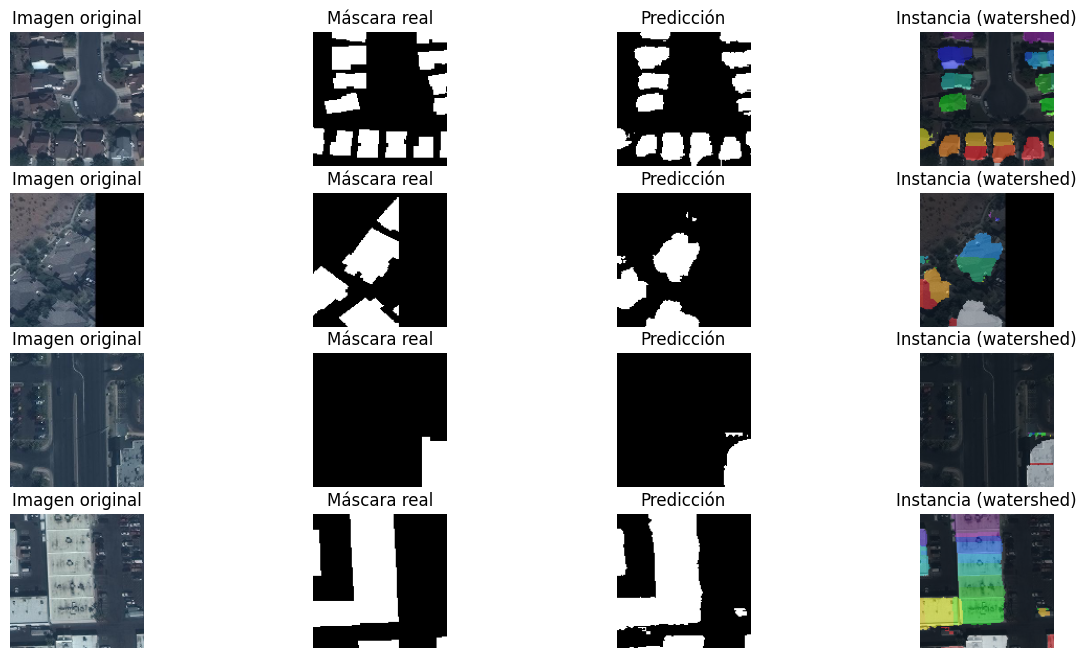

In [26]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from matplotlib import colors

# Visualizamos algunos resultados con watershed
for batch in val_ds_unet.take(1):
    imagenes, mascaras = batch
    preds = modelo_guardado.predict(imagenes)

    num_ejemplos = 4
    plt.figure(figsize=(15, 8))
    for i in range(num_ejemplos):
        # Imagen original
        plt.subplot(num_ejemplos, 4, 4*i + 1)
        plt.imshow(imagenes[i].numpy())
        plt.title("Imagen original")
        plt.axis("off")

        # Máscara real
        plt.subplot(num_ejemplos, 4, 4*i + 2)
        plt.imshow(mascaras[i].numpy().squeeze(), cmap='gray')
        plt.title("Máscara real")
        plt.axis("off")

        # Predicción U-Net
        pred_binaria = (preds[i].squeeze() > 0.5).astype(np.uint8)

        plt.subplot(num_ejemplos, 4, 4*i + 3)
        plt.imshow(pred_binaria, cmap='gray')
        plt.title("Predicción")
        plt.axis("off")

        # Aplicar watershed
        distance_map = ndi.distance_transform_edt(pred_binaria)
        local_maxi = peak_local_max(distance_map, indices=False, labels=pred_binaria)
        markers, _ = ndi.label(local_maxi)
        labels_ws = watershed(-distance_map, markers, mask=pred_binaria)

        # Colorear labels
        cmap = plt.get_cmap("nipy_spectral")
        norm = colors.Normalize(vmin=0, vmax=labels_ws.max())
        labels_rgb = cmap(norm(labels_ws))[:, :, :3]

        # Superponer sobre imagen original
        alpha = 0.5
        overlay = (1 - alpha) * imagenes[i].numpy() + alpha * labels_rgb
        overlay = np.clip(overlay, 0, 1)

        plt.subplot(num_ejemplos, 4, 4*i + 4)
        plt.imshow(overlay)
        plt.title(f"Instancia (watershed)")
        plt.axis("off")

    plt.show()


Transformacion con watershed

In [2]:
# Cargamos la imagen
imagen = cv2.imread("../DATASETS/DATASET_FINAL/Satellite-view-of-the-mixed-use-building.png")
if imagen is None:
    print("No se pudo leer la imagen:", "ruta/a/imagen.png")
else:
    img_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

NameError: name 'cv2' is not defined

In [29]:
img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128,128))  # tamaño de entrada de tu U-Net
img_input = np.expand_dims(img_resized/255.0, axis=0)

In [30]:
# Cogemos la prediccion
prediccion_modelo = modelo_guardado.predict(img_input)[0,:,:,0]  # asumir salida (H,W,1)

1/1 [==============================] - 0s 167ms/step


In [31]:
# Lo convertimos a mascaras binarias
mascaras_binarias_pred = (prediccion_modelo > 0.5).astype(np.uint8)

In [32]:
# Calculamos el mapa de distancia
distance_map = ndi.distance_transform_edt(mascaras_binarias_pred)

In [33]:
# Calculamos los máximos locales
local_maxi = local_maxima(distance_map)
markers, _ = ndi.label(local_maxi)

In [34]:
# Aplicamos watershed
labels = watershed(-distance_map, markers, mask=mascaras_binarias_pred)

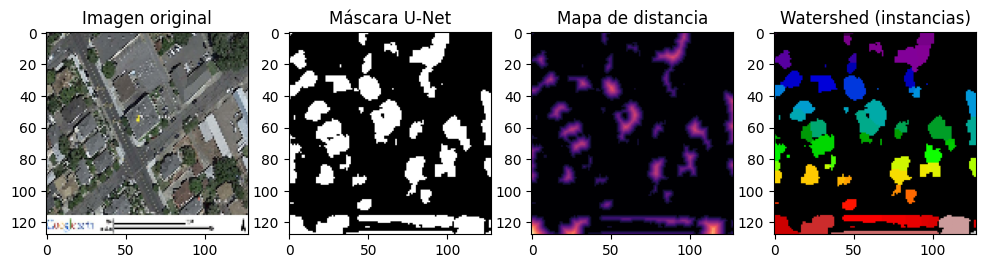

Número de objetos detectados: 76


In [35]:
# Visualizamos el resultado
plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(img_resized); plt.title("Imagen original")
plt.subplot(1,4,2); plt.imshow(mascaras_binarias_pred, cmap="gray"); plt.title("Máscara U-Net")
plt.subplot(1,4,3); plt.imshow(distance_map, cmap="magma"); plt.title("Mapa de distancia")
plt.subplot(1,4,4); plt.imshow(labels, cmap="nipy_spectral"); plt.title("Watershed (instancias)")
plt.show()

# Opcional: cuántos objetos detectó
print("Número de objetos detectados:", labels.max())

1/1 [==============================] - 0s 110ms/step


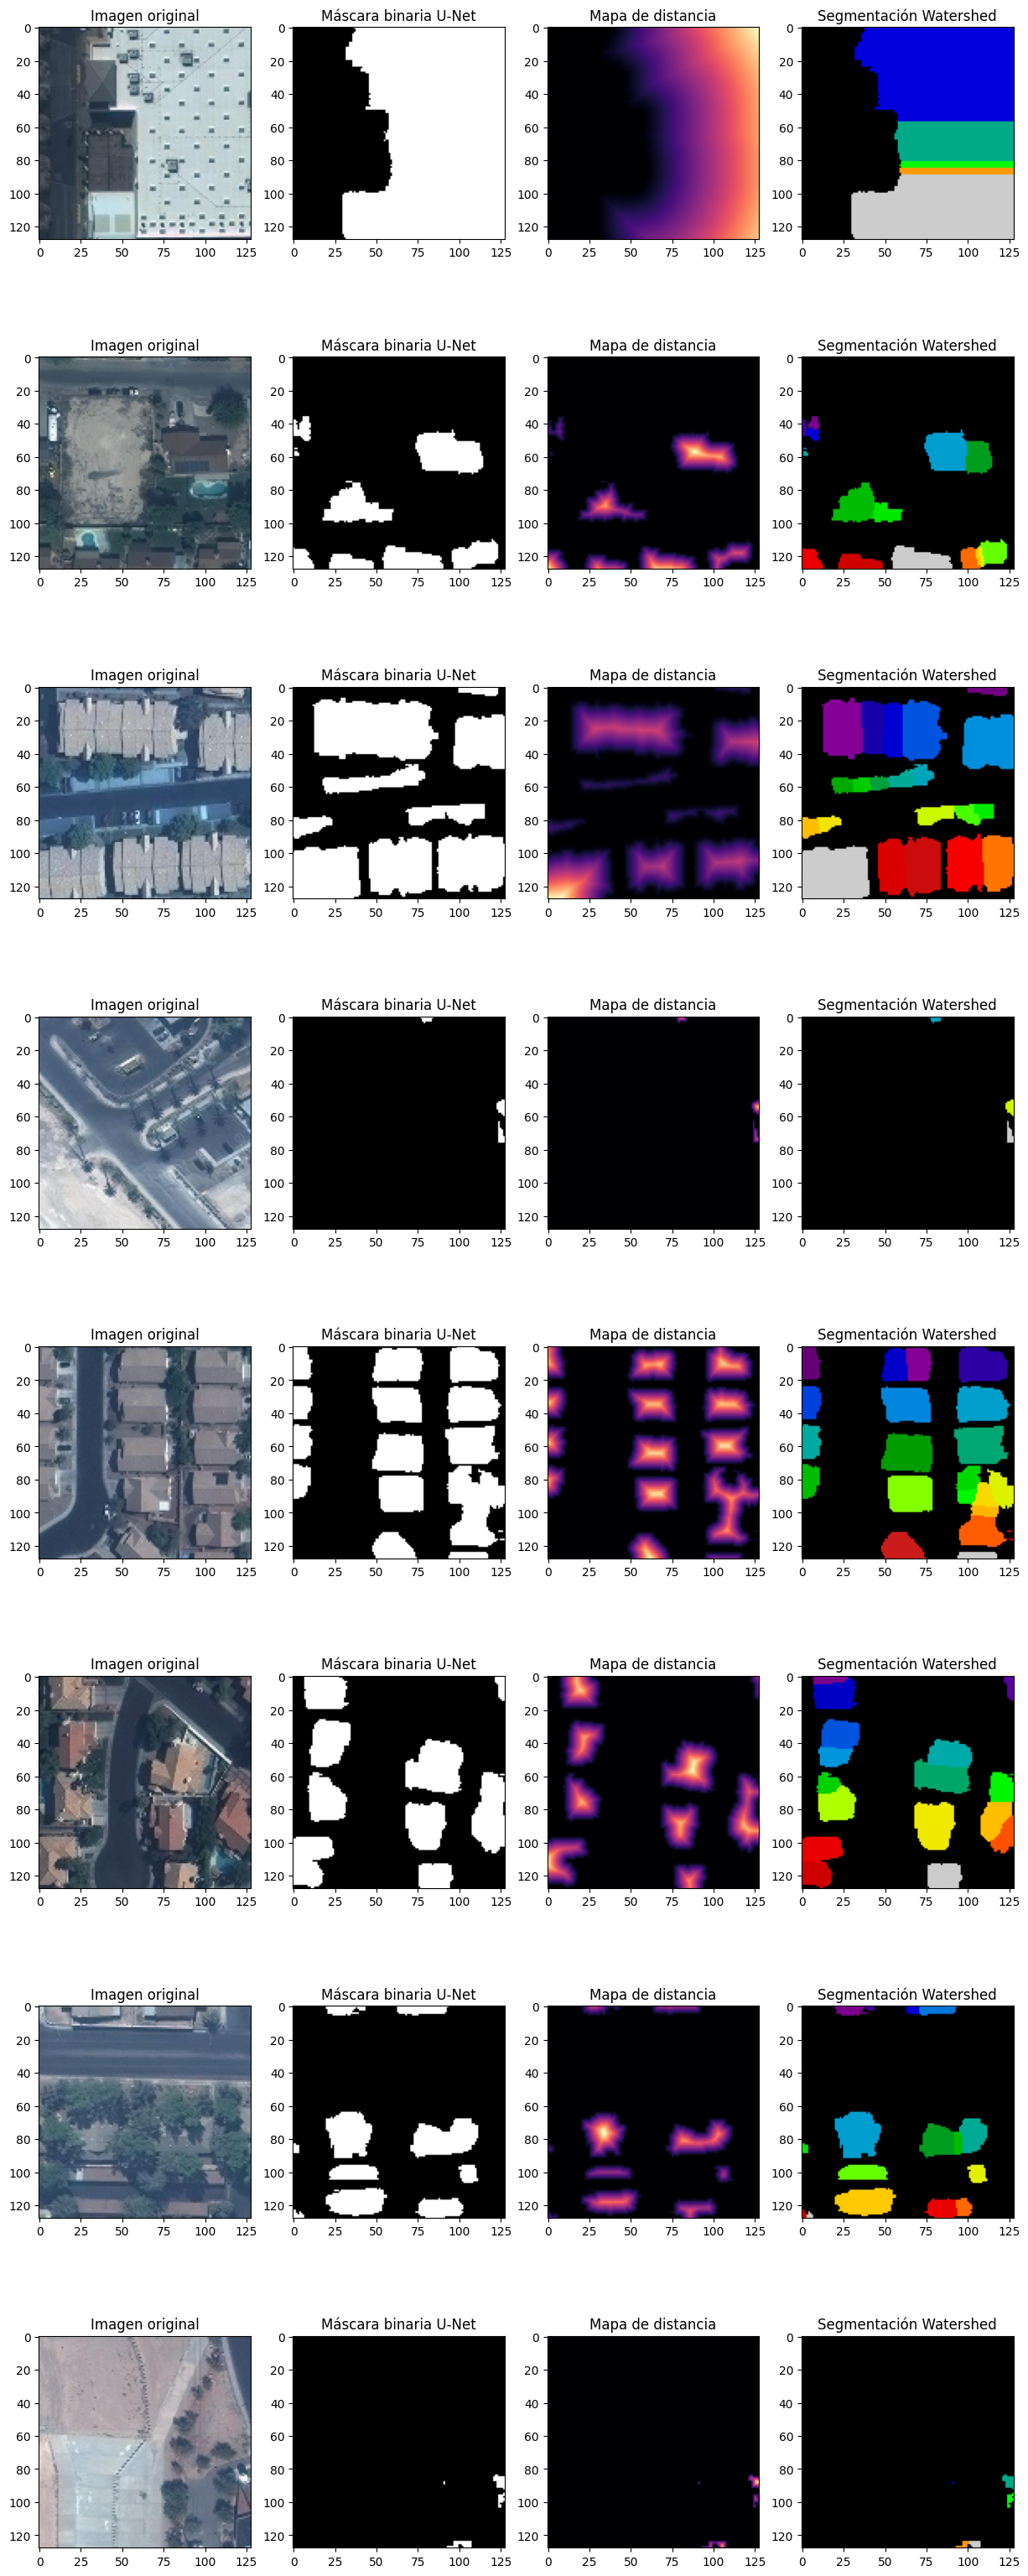

In [36]:
# Visualizamos
for imgs, masks in val_ds_unet.take(1):
    preds = modelo_guardado.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.uint8)

    plt.figure(figsize=(15,5*len(preds_bin)))
    for i in range(len(preds_bin)):
        mask = preds_bin[i].squeeze()

        # 1️⃣ Calcular mapa de distancia
        distance_map = ndi.distance_transform_edt(mask)

        # 2️⃣ Detectar máximos locales -> marcadores
        local_maxi = local_maxima(distance_map)
        markers, _ = ndi.label(local_maxi)

        # 3️⃣ Aplicar Watershed
        labels = watershed(-distance_map, markers, mask=mask)

        # 4️⃣ Visualizar resultados
        plt.subplot(len(preds_bin), 4, 4*i + 1)
        plt.imshow(imgs[i].numpy())
        plt.title("Imagen original")

        plt.subplot(len(preds_bin), 4, 4*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Máscara binaria U-Net")

        plt.subplot(len(preds_bin), 4, 4*i + 3)
        plt.imshow(distance_map, cmap="magma")
        plt.title("Mapa de distancia")

        plt.subplot(len(preds_bin), 4, 4*i + 4)
        plt.imshow(labels, cmap="nipy_spectral")
        plt.title("Segmentación Watershed")
    plt.show()

1/1 [==============================] - 0s 63ms/step


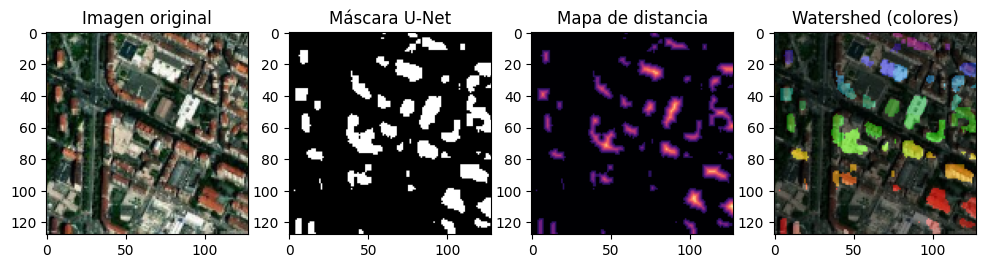

Número de objetos detectados: 71


In [13]:
# Cargamos la imagen
from matplotlib import colors
imagen = cv2.imread("../DATASETS/DATASET_FINAL/images.jpg")
img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128, 128))  # tamaño de entrada de tu U-Net
img_input = np.expand_dims(img_resized / 255.0, axis=0)
# Cogemos la prediccion
prediccion_modelo = modelo_guardado.predict(img_input)[0, :, :, 0]  # asumir salida (H,W,1)
# Lo convertimos a mascaras binarias
mascaras_binarias_pred = (prediccion_modelo > 0.5).astype(np.uint8)
# Calculamos el mapa de distancia
distance_map = ndi.distance_transform_edt(mascaras_binarias_pred)
# Calculamos los máximos locales
local_maxi = local_maxima(distance_map)
markers, _ = ndi.label(local_maxi)
# Aplicamos watershed
labels = watershed(-distance_map, markers, mask=mascaras_binarias_pred)
# 1️⃣ Normalizamos labels para colorear
cmap = plt.get_cmap("nipy_spectral")  # colormap colorido
norm = colors.Normalize(vmin=0, vmax=labels.max())
# Convertimos labels a imagen RGB
labels_rgb = cmap(norm(labels))[:, :, :3]  # toma solo canales RGB, descarta alpha
# 2️⃣ Superponer sobre imagen original
alpha = 0.5  # transparencia del overlay
overlay = (1 - alpha) * (img_resized / 255.0) + alpha * labels_rgb
overlay = np.clip(overlay, 0, 1)  # asegurar que esté entre 0 y 1
# Visualizamos el resultado
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1);
plt.imshow(img_resized);
plt.title("Imagen original")
plt.subplot(1, 4, 2);
plt.imshow(mascaras_binarias_pred, cmap="gray");
plt.title("Máscara U-Net")
plt.subplot(1, 4, 3);
plt.imshow(distance_map, cmap="magma");
plt.title("Mapa de distancia")
plt.subplot(1, 4, 4);
plt.imshow(labels, cmap="nipy_spectral");
plt.title("Watershed (instancias)")
plt.subplot(1, 4, 4);
plt.imshow(overlay);
plt.title("Watershed (colores)")
plt.show()

# Opcional: cuántos objetos detectó
print("Número de objetos detectados:", labels.max())

1/1 [==============================] - 0s 48ms/step


C:\Users\kiler\AppData\Local\Temp\ipykernel_14220\4024286017.py:13: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance_map, indices=False, footprint=np.ones((3,3)))


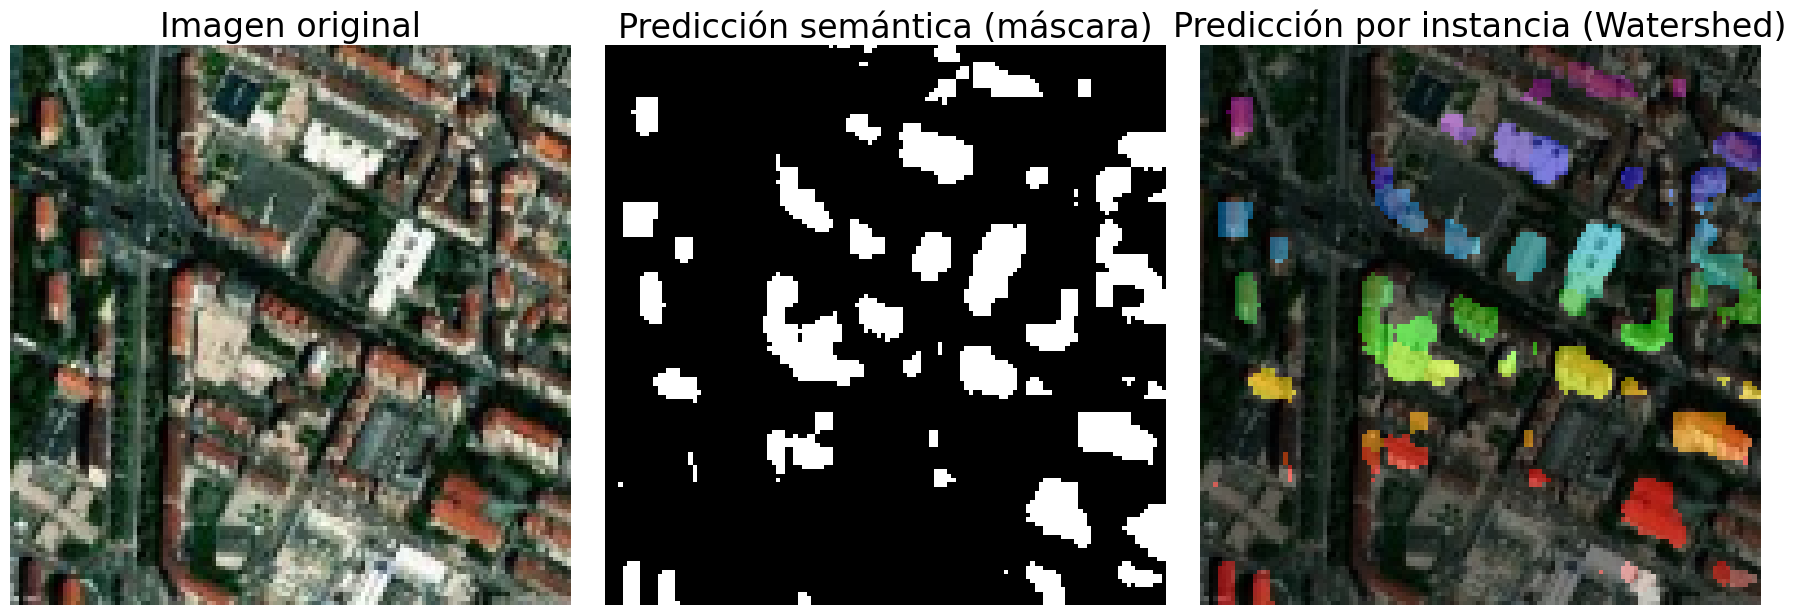

In [27]:
# Cargamos la imagen
imagen = cv2.imread("../DATASETS/DATASET_FINAL/images.jpg")
img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128, 128))
img_input = np.expand_dims(img_resized / 255.0, axis=0)

# Predicción
prediccion_modelo = modelo_guardado.predict(img_input)[0, :, :, 0]
mascara_binaria = (prediccion_modelo > 0.5).astype(np.uint8)

# Mapa de distancia y watershed
distance_map = ndi.distance_transform_edt(mascara_binaria)
local_maxi = peak_local_max(distance_map, indices=False, footprint=np.ones((3,3)))
markers, _ = ndi.label(local_maxi)
labels = watershed(-distance_map, markers, mask=mascara_binaria)

# Colorear labels
cmap = plt.get_cmap("nipy_spectral")
norm = colors.Normalize(vmin=0, vmax=labels.max())
labels_rgb = cmap(norm(labels))[:, :, :3]

# Overlay con la imagen original
alpha = 0.5
overlay = np.clip((1 - alpha) * (img_resized / 255.0) + alpha * labels_rgb, 0, 1)

# Visualización
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Imagen original", fontsize=24)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mascara_binaria, cmap="gray")
plt.title("Predicción semántica (máscara)", fontsize=24)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Predicción por instancia (Watershed)", fontsize=24)
plt.axis("off")

plt.tight_layout()
plt.show()